# Machine Learning used to analyse Learning Analytics with K-Means Clustering

**John McClane, Zep Addicted**<br> 
*NTUA*

**April 2022**

## Introduction
<p>
    In this article, we will explore K-Means Clustering:<br>
    <ul>
        <li><a href="#definition"> What is K-Means Clustering? </li>
        <li><a href="#algorithm">Algorithm</a></li>
        <li><a href="#application">K-Means Clustering Application: Analysing Learning Analytics</a></li>
    </ul>
</p>

Jupyter Notebooks are available on [Github](https://github.com/John-McClane/wp-experience-api).

For this project, we use several Python-based scientific computing technologies listed below.

In [1]:
import kneed
import requests
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import json_normalize
from tqdm import tqdm
from time import time
import seaborn as sns
import ipywidgets as widgets 
from scipy.stats import mstats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from requests.exceptions import ConnectionError
from requests.packages.urllib3.util.retry import Retry

import sys
import os
import pymongo
from ssh_pymongo import MongoSession
import logging
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

<a name="definition"></a>
<h2><span>What is K-Means Clustering?  </span></h2>
<p>
K-Means Clustering is a form of unsupervised <a href="https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826">machine learning</a> (ML). It is considered to be one of the simplest and most popular unsupervised machine learning techniques.
Unsupervised algorithms use vectors on data points. These data points are not labeled or classified. Our goal is to discover hidden patterns and group the data points in a sensible way based on similarity of features. Each group of data points is a cluster and each cluster will have a center.

<img src="img/k_means.png">

<a href="https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/">Source : Analytics Vidhya </a>

### Examples

Let's imagine you have two dimensional data that is not labeled as shown below and you are asked to form clusters.

#### Row data

<img src="img/k_means_row_data.PNG">

Below is an example of good clustering.

#### Good Clustering

<img src="img/k_means_good_clustering.PNG" >

However, clustering can go wrong as seen below.

#### Naive Clustering

<img src="img/k_means_bad_clustering.PNG" >

Source: Oreilly.com : Clustering and Unsupervised Learning

<a name="algorithm"></a>
<h2><span>Algorithm </span></h2>

* Pre-process the data (Clean it, Scale it, Standardize it)
* Select K
* Pick K Centers 
* Repeat until there is no change of the centroid positions: <BR>
   1) Compute the distance between data point (vector x) and all centroids. (Generally, we use the euclidean distance) <BR>
    <img src="img/k_means_euclidean.png" >
   2) Assign each data point to the closest cluster (centroid) <BR>
    <img src="img/k_means_argmin.png" >
   3) Compute the centroids for the clusters by taking the average of all data points that belong to each cluster.
 

 <img src="img/k_means_algorithm.PNG"  width="50%" > <BR>
 <img src="img/k_means_algorithm_gif.gif">
 

Training examples are shown as dots, and cluster centroids are shown as crosses.
    <ul>
        (a) Original dataset.<br>
        (b) Random initial cluster centroids.<br>
        (c-f) Illustration of running two iterations of k-means.<br>
    </ul>
In each iteration, we assign each training example to the closest cluster centroid (shown by "painting" the training examples the same color as the cluster centroid to which it is assigned). Then we move each cluster centroid to the mean of the points assigned to it.

<a href="https://stanford.edu/~cpiech/cs221/handouts/kmeans.html">Source : Stanford Edu ( K-Means) </a>


<a name="application"></a>
<h2><span>K-Means Clustering Application: Analysing Learning Analytics </span></h2>

We are going to use K-Means Clustering to analyse Learning Analytics Data. <BR>
<ul>
    <li><code>Learning Locker LRS:</code> Learning Locker LRS is used to capture Learning Analytics Data.</li>
    <li><code>Analysis:</code> The data is stored in MongoDB in the LRS and retrieved to perform analysis.</li>

</ul>
The idea is to create clusters with similar characteristics for the variables of the Learning Analytics data.<br><br>
    
Please note that this analysis is done using only two factors which leads to a two dimensional problem. We are using a two dimensional problem to demonstrate the concept and understand the problem. Multiple factors can be used as well. If you want to use multiple factors, you may want to use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">Principal Component Analysis</a> to lower the number of dimensions. <br><br>
   
We will proceed with the following steps: <br><b>K-Means Clustering : </b><br>

    1. Get the data: Connect to Remote Host to retrieve MongoDB data regarding Learning Analytics captured using Learning Locker LRS.
    2. Analyze the data, clean it and visualize it.
    3. Choose K.
    4. Analyze the clustering results.
<b>Risk Assesment: </b><br>
    
    1. From each cluster, choose the variables with the highest risk adjusted momentum. 
    2. Run the data return prediction for next time period.

----
Let's apply the steps defined above:
## K-Means Clustering 
### <I>1. Get the data: Connect to Remote Machine and retrieve MongoDB LL LRS Learning Analytics Data</I>

In [2]:
# #############################################################################
# Set Debug Level. Silent = 0, Info = 1, Debug = 2
debug = 2

# #############################################################################
# Fetch MongoDB LL LRS Learning Analytics Data from Remote Machine
# Read MongoSessionCredentials from file
# MongoSessionCredentials.txt file format should be: host (192.168.2.2), user, key (full path /home/id_rsa), key_password (Key_P@ssword), uri (mongodb://127.0.0.1:27017). Separated by newline. No "", no ''.
filepath = "MongoSessionCredentials.txt"
if not os.path.isfile(filepath):
   print("File path {} does not exist. Exiting...".format(filepath))
   raise Exception("Exiting")
with open(filepath) as fp :
    mylist = fp.read().splitlines()
    mhost = mylist[0]
    muser = mylist[1]
    mkey = mylist[2]
    mkeypas = mylist[3]
    muri = mylist[4]
if debug > 1 :
    print("MongoSessionCredentials: mhost:",mhost,"muser:",muser,"mkey:",mkey,"mkeypas:",mkeypas,"muri:",muri,"\n")
    print("MongoSessionCredentials")
    mhost,muser,mkey,mkeypas,muri

# #############################################################################
# Initiate a Connection Session to Remote Machine and MongoDB
session = MongoSession(
    host=mhost,
    user=muser,
    key=mkey,
    key_password=mkeypas,
    uri=muri
)

#retry_strategy = Retry(total=3, backoff_factor=10, status_forcelist=[429, 500, 502, 503, 504], allowed_methods=["HEAD", "GET", "PUT", "DELETE", "OPTIONS", "TRACE"])
data = []
lldb = []

try:
    # Connect to Remote Machine and MongoDB Learning Locker LRS Collection "statement"
    lldb = session.connection['learninglocker_v2'] #(max_retries=retry_strategy)
    print("\nDataBase Connection Info:\n", lldb, "\n")
    if debug > 0 :
        print("\nCollections Names List:\n",lldb.list_collection_names(include_system_collections=False),"\n")
    # Get Learning Analytics statements from MongoDB Learning Locker LRS from collection "statement"
    statements_coll = lldb.statements
    print("\nCollection Statements:\n",statements_coll, "\n")
    t0=time()   
    print("\n########## Execution Time: %0.3fs" % (time() - t0), "\n")

except requests.exceptions.RequestException as err:
    print ("Oops: Something Else",err)
except requests.exceptions.HTTPError as errh:
    print ("HTTP Error:",errh)
except requests.exceptions.ConnectionError as errc:
    print ("Error Connecting:",errc)
except requests.exceptions.Timeout as errt:
    print ("Timeout Error:",errt)
except:
    pass

# #############################################################################
# Convert data to DataFrame
df = json_normalize(list(
statements_coll.aggregate([
#        {
#            "$match": query
#        },
        {
            "$replaceRoot": {
                "newRoot": "$statement"
            }
        },
        { "$sort": { "stored": -1 } },
        { "$limit": 30 }
    ])
))

if debug > 0 :
    print("Type of df:",type(df))

if debug > 2 :
    # Printing the df to console
    print(df)

session.stop()
t1=time()
print("\n########## Execution Time: %0.3fs" % (time() - t1), "\n")

data = df
if debug > 0 :
    print ("\nData Length")
    len(data)
if debug > 0 :
    print ("\nData Shape")
    data.shape
if debug > 0 :
    print ("\nData Description")
    data.describe()
if debug > 1 :
    print ("\nData")
    data

MongoSessionCredentials: mhost: 147.102.13.149 muser: root mkey: /mnt/c/1/xdoc/pandas/id_rsa mkeypas: M!Spy=76wn4SH]>n4L%& muri: mongodb://127.0.0.1:27017 

MongoSessionCredentials


('147.102.13.149',
 'root',
 '/mnt/c/1/xdoc/pandas/id_rsa',
 'M!Spy=76wn4SH]>n4L%&',
 'mongodb://127.0.0.1:27017')

2022-04-19 12:24:04,584| ERROR   | Password is required for key /home/admin/.ssh/id_rsa
2022-04-19 12:24:04,584 ERROR Password is required for key /home/admin/.ssh/id_rsa
2022-04-19 12:24:04,668 INFO Connected (version 2.0, client OpenSSH_7.6p1)
2022-04-19 12:24:05,573 INFO Authentication (publickey) successful!



DataBase Connection Info:
 Database(MongoClient(host=['127.0.0.1:35015'], document_class=dict, tz_aware=False, connect=True), 'learninglocker_v2') 


Collections Names List:
 ['importcsv', 'personaAttributes', 'dashboards', 'migrations', 'personasImportTemplates', 'queryBuilderCacheValues', 'statements', 'lrs', 'batchDelete', 'orgUsageStats', 'exports', 'client', 'queries', 'users', 'queryBuilderCaches', 'statementForwarding', 'personaIdentifiers', 'organisations', 'downloads', 'personasImports', 'siteSettings', 'states', 'oAuthTokens', 'personas', 'role', 'fullActivities', 'importPersonasLock', 'streams', 'visualisations', 'importdata'] 


Collection Statements:
 Collection(Database(MongoClient(host=['127.0.0.1:35015'], document_class=dict, tz_aware=False, connect=True), 'learninglocker_v2'), 'statements') 


########## Execution Time: 0.000s 

Type of df: <class 'pandas.core.frame.DataFrame'>

########## Execution Time: 0.000s 


Data Length


30


Data Shape


(30, 21)


Data Description


,timestamp,id,stored,version,actor.objectType,actor.name,actor.mbox,verb.id,verb.display.en-US,context.platform,...,context.extensions.http://id&46;tincanapi&46;com/extension/browser-info.user_agent,context.extensions.http://id&46;tincanapi&46;com/extension/referrer,object.objectType,object.id,object.definition.type,object.definition.name.en-US,object.definition.description.en-US,authority.objectType,authority.name,authority.mbox
count,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
unique,30,30,30,1,1,28,28,1,1,1,...,24,2,1,10,1,8,1,1,1,1
top,2021-12-29T04:39:20+00:00,e7048d33-82cc-4d60-b29f-14d604203d53,2021-12-29T04:39:25.224Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
freq,1,1,1,30,30,2,2,30,30,30,...,3,29,30,21,30,22,30,30,30,30



Data


,timestamp,id,stored,version,actor.objectType,actor.name,actor.mbox,verb.id,verb.display.en-US,context.platform,...,context.extensions.http://id&46;tincanapi&46;com/extension/browser-info.user_agent,context.extensions.http://id&46;tincanapi&46;com/extension/referrer,object.objectType,object.id,object.definition.type,object.definition.name.en-US,object.definition.description.en-US,authority.objectType,authority.name,authority.mbox
0,2021-12-29T04:39:20+00:00,e7048d33-82cc-4d60-b29f-14d604203d53,2021-12-29T04:39:25.224Z,1.0.0,Agent,Guest.115.29.199.218,mailto:guest.115.29.199.218@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
1,2021-12-29T04:23:58+00:00,1de0f462-f2d5-4822-a246-c07a925eb447,2021-12-29T04:23:58.246Z,1.0.0,Agent,Guest.212.103.4.29,mailto:guest.212.103.4.29@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
2,2021-12-29T04:08:55+00:00,6a984cb0-92ff-48a1-a632-b77f53494390,2021-12-29T04:08:55.557Z,1.0.0,Agent,Guest.188.166.152.29,mailto:guest.188.166.152.29@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
3,2021-12-29T03:53:54+00:00,bc89786b-5544-4597-a1ef-7ee665a53e2f,2021-12-29T03:53:54.498Z,1.0.0,Agent,Guest.35.241.177.128,mailto:guest.35.241.177.128@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
4,2021-12-29T03:38:45+00:00,d3bd2bfd-3350-4b23-9d22-37d447a08a47,2021-12-29T03:38:45.230Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
5,2021-12-29T03:23:35+00:00,48033410-76a9-4e4c-b098-9c867d5de538,2021-12-29T03:23:35.118Z,1.0.0,Agent,Guest.65.21.234.156,mailto:guest.65.21.234.156@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
6,2021-12-29T02:52:57+00:00,27c2cd27-b061-469c-ad77-1e89a1585056,2021-12-29T02:52:57.445Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
7,2021-12-29T02:50:17+00:00,d684ce9e-4bbf-478d-bc8f-bc8a70e630e5,2021-12-29T02:50:17.697Z,1.0.0,Agent,Guest.207.46.13.197,mailto:guest.207.46.13.197@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,,Activity,https://webvm.netmode.ntua.gr/courses/?lecture...,http://activitystrea.ms/schema/1.0/page,"Διαχείριση Δικτύων – Ευφυή Δίκτυα, 9ο Εξάμηνο,...",Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
8,2021-12-29T02:22:20+00:00,404fb2f5-ba7d-4463-a699-0de42d7037bb,2021-12-29T02:22:20.463Z,1.0.0,Agent,Guest

In [3]:
# Remove any % characters, change string values to numeric values
#data[["Return on Assets"]] = data[["Return on Assets"]].apply(lambda x: x.str.replace('[%]','', regex=True))
#data[["Return on Assets", 
#      "Rev per share"]] = data[["Return on Assets", 
#                                   "Rev per share"]].apply(pd.to_numeric)
#data[["Return on Assets"]] = data[["Return on Assets"]].apply(lambda x: x/100)
#data.index.name = 'ID'

#data

### <I>2. Analyze the data, clean it and visualize it.</I>

In [4]:
if debug > 0 :
    print ("\nData Shape")
    data.shape
    
if debug > 0 :
    print ("\nData Description")
    data.describe()


Data Shape


(30, 21)


Data Description


,timestamp,id,stored,version,actor.objectType,actor.name,actor.mbox,verb.id,verb.display.en-US,context.platform,...,context.extensions.http://id&46;tincanapi&46;com/extension/browser-info.user_agent,context.extensions.http://id&46;tincanapi&46;com/extension/referrer,object.objectType,object.id,object.definition.type,object.definition.name.en-US,object.definition.description.en-US,authority.objectType,authority.name,authority.mbox
count,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
unique,30,30,30,1,1,28,28,1,1,1,...,24,2,1,10,1,8,1,1,1,1
top,2021-12-29T04:39:20+00:00,e7048d33-82cc-4d60-b29f-14d604203d53,2021-12-29T04:39:25.224Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
freq,1,1,1,30,30,2,2,30,30,30,...,3,29,30,21,30,22,30,30,30,30


In [5]:
# Make a copy of the original data before starting our data preprocessing
original_data=data.copy()

#Check NA Values
data[data['verb.display.en-US'].isna() | data['actor.name'].isna()]

,timestamp,id,stored,version,actor.objectType,actor.name,actor.mbox,verb.id,verb.display.en-US,context.platform,...,context.extensions.http://id&46;tincanapi&46;com/extension/browser-info.user_agent,context.extensions.http://id&46;tincanapi&46;com/extension/referrer,object.objectType,object.id,object.definition.type,object.definition.name.en-US,object.definition.description.en-US,authority.objectType,authority.name,authority.mbox


In [6]:
# Dropna value 
data=data.dropna()
data

,timestamp,id,stored,version,actor.objectType,actor.name,actor.mbox,verb.id,verb.display.en-US,context.platform,...,context.extensions.http://id&46;tincanapi&46;com/extension/browser-info.user_agent,context.extensions.http://id&46;tincanapi&46;com/extension/referrer,object.objectType,object.id,object.definition.type,object.definition.name.en-US,object.definition.description.en-US,authority.objectType,authority.name,authority.mbox
0,2021-12-29T04:39:20+00:00,e7048d33-82cc-4d60-b29f-14d604203d53,2021-12-29T04:39:25.224Z,1.0.0,Agent,Guest.115.29.199.218,mailto:guest.115.29.199.218@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
1,2021-12-29T04:23:58+00:00,1de0f462-f2d5-4822-a246-c07a925eb447,2021-12-29T04:23:58.246Z,1.0.0,Agent,Guest.212.103.4.29,mailto:guest.212.103.4.29@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
2,2021-12-29T04:08:55+00:00,6a984cb0-92ff-48a1-a632-b77f53494390,2021-12-29T04:08:55.557Z,1.0.0,Agent,Guest.188.166.152.29,mailto:guest.188.166.152.29@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
3,2021-12-29T03:53:54+00:00,bc89786b-5544-4597-a1ef-7ee665a53e2f,2021-12-29T03:53:54.498Z,1.0.0,Agent,Guest.35.241.177.128,mailto:guest.35.241.177.128@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
4,2021-12-29T03:38:45+00:00,d3bd2bfd-3350-4b23-9d22-37d447a08a47,2021-12-29T03:38:45.230Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
5,2021-12-29T03:23:35+00:00,48033410-76a9-4e4c-b098-9c867d5de538,2021-12-29T03:23:35.118Z,1.0.0,Agent,Guest.65.21.234.156,mailto:guest.65.21.234.156@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
6,2021-12-29T02:52:57+00:00,27c2cd27-b061-469c-ad77-1e89a1585056,2021-12-29T02:52:57.445Z,1.0.0,Agent,Guest.109.168.97.89,mailto:guest.109.168.97.89@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,,Activity,https://lectures.netmode.ntua.gr/wp-login.php,http://activitystrea.ms/schema/1.0/page,,Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
7,2021-12-29T02:50:17+00:00,d684ce9e-4bbf-478d-bc8f-bc8a70e630e5,2021-12-29T02:50:17.697Z,1.0.0,Agent,Guest.207.46.13.197,mailto:guest.207.46.13.197@ntua-guest.com,http://id.tincanapi.com/verb/viewed,viewed,Unknown,...,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,,Activity,https://webvm.netmode.ntua.gr/courses/?lecture...,http://activitystrea.ms/schema/1.0/page,"Διαχείριση Δικτύων – Ευφυή Δίκτυα, 9ο Εξάμηνο,...",Viewed Page,Agent,NTUA NetMODe,mailto:info@netmode.ntua.gr
8,2021-12-29T02:22:20+00:00,404fb2f5-ba7d-4463-a699-0de42d7037bb,2021-12-29T02:22:20.463Z,1.0.0,Agent,Guest

(0.0, 200.0)

Text(0.5, 1.0, 'Original Data')

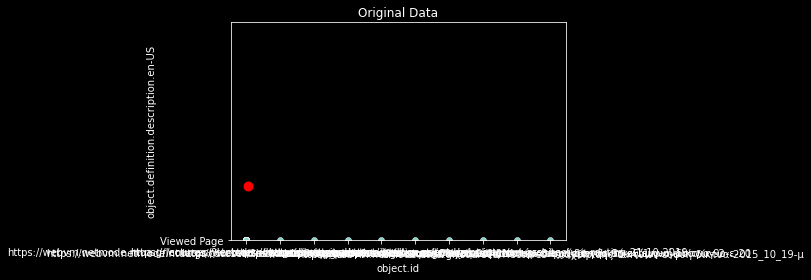

In [7]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='object.id', y='object.definition.description.en-US', data=data)
plt.ylim([0,200])
plt.title("Original Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')

In [8]:
# Both Revenue per share and Return on Assets are ratios. They are already scaled to the company size.
# We can use Winsorization to transforms data by limiting extreme values, typically by setting all outliers to a specified percentile of data
X =np.asarray([np.asarray(data['Return on Assets']),np.asarray(data['Rev per share'])])
X = mstats.winsorize(X, limits = [0.05, 0.05])
data=pd.DataFrame(X, index=['Return on Assets','Rev per share'], columns=data.index).T
data.head()

KeyError: 'Return on Assets'

In [ ]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', data=data)
plt.title("Winsorized Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')
plt.show()

### <I>3. Choose K</I>

The two most common methods to choose K ( the appropriate number of clusters) are :
    <ul>
        <li>The silhouette Coefficient</li>
        <li>The Elbow Method </li>
    </ul>

The silhouette coefficient is a value that ranges between -1 and 1. It quantifies how well a data point fits into its assigned cluster based on two factors:
1. How close the data point is to other points in the cluster
2. How far away the data point is from points in other clusters

Larger numbers for Silhouette coefficient indicate that samples are closer to their clusters than they are to other clusters.

The elbow method is used by running several k-means, increment k with each iteration, and record the SSE ( Sum Of Squared Error) <br><br>
$$SSE= Sum  \; Of  \; Euclidean  \; Squared  \; Distances  \; of  \; each  \; point \; to \; its  \; closest \; centroid $$<br>
After that , we plot SSE as a function of the number of clusters. SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.
There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. <br>

<a href="https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters"> (Source)</a>

In this example, we will use the Elbow Method to determine K:

In [ ]:
distorsions = []
clusters_iterations=range(2, 20)
for k in clusters_iterations:
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    distorsions.append(k_means.inertia_)

In [ ]:
elbow_curve_data=pd.DataFrame(zip(clusters_iterations,distorsions),columns=['Cluster','SSE']).set_index('Cluster')
elbow_curve_data.head()

In [ ]:
# Visualize plot
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.plot(elbow_curve_data['SSE'])
plt.title("Elbow Curve")

plt.show()

In [ ]:
# get elbow programmatically
from kneed import KneeLocator 
kl = KneeLocator(
clusters_iterations, distorsions, curve="convex", direction="decreasing")
elbow=kl.elbow

print('Elbow = {}'.format(elbow))

### <I>4. Analyze the clustering results</I>

In [ ]:
# We apply KMeans for the Elbow's value  ( in this case = 5)
kmeans = KMeans(n_clusters=elbow)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
df_kmeans = data.copy()
df_kmeans['cluster']=y_kmeans.astype(str)

In [ ]:
# Visualize the results
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', hue=df_kmeans['cluster'].astype(int), 
                    palette=['blue','green','yellow','orange','red'], data=df_kmeans)
plt.title("K-Means Clustering")

# Some random point we want to classify
plt.show()

In [ ]:
# see the centers 
clusters_centers_df=pd.DataFrame(kmeans.cluster_centers_,columns=['Return on Assets','Rev per share'])
clusters_centers_df

In [ ]:
# See the clustering by Company 
clustering_result=pd.DataFrame(zip(y_kmeans,data.index),columns=['Cluster','Company'])
clustering_result.set_index('Cluster').head()

In [ ]:
for cluster_num in list(clustering_result.set_index('Cluster').index.unique()):
    print (clustering_result.set_index('Cluster').loc[cluster_num].head())

In [ ]:
# Enrich Centers Df with the number of elements by Cluster
clusters_centers_df['Count']=clustering_result['Cluster'].value_counts().to_frame().rename(columns={'Cluster':'Count'})['Count']
clusters_centers_df.head()

In [ ]:
# Visualize Count of Elements by Cluster 
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.bar(clusters_centers_df.index.values,clusters_centers_df['Count'])
plt.title("Count of Elements by Cluster")

plt.show()

## Portfolio Construction
### <I>1. From each cluster, choose the stocks with the highest Risk Adjusted Momentum </I>

We can use the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints) to pull in the two year historical prices.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [ ]:
#fetch 2 year daily return data

url = "https://stock-prices2.p.rapidapi.com/api/v1/resources/stock-prices/2y"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

stock_frames = []

# for ticker in stock_tickers:
for ticker in tqdm(stock_tickers, position=0, leave=True, desc = "Retrieving AlphaWave Data Stock Info"):
    
    querystring = {"ticker":ticker}
    stock_daily_price_response = requests.request("GET", url, headers=headers, params=querystring)

    # Create Stock Prices DataFrame
    stock_daily_price_df = pd.DataFrame.from_dict(stock_daily_price_response.json())
    stock_daily_price_df = stock_daily_price_df.transpose()
    stock_daily_price_df = stock_daily_price_df.rename(columns={'Close':ticker})
    stock_daily_price_df = stock_daily_price_df[{ticker}]
    stock_frames.append(stock_daily_price_df)

combined_stock_price_df = pd.concat(stock_frames, axis=1, sort=True)
combined_stock_price_df = combined_stock_price_df.dropna(how='all')
combined_stock_price_df = combined_stock_price_df.fillna("")
combined_stock_price_df

In [ ]:
# Build of Portfolio of 50 stocks
number_of_stocks=50

# From each Cluster, we will pick the stocks with the highest risk adjusted momentum. The number of stocks from each cluster is proportional to its size
# Let's start by calculate the number of stocks to pick from each cluster
number_of_stocks_by_cluster=pd.DataFrame(round(number_of_stocks*clustering_result.groupby(by='Cluster').count()['Company']/clustering_result.count()['Company'],0))
number_of_stocks_by_cluster

In [ ]:
# From each Cluster, pick the stocks with the highest risk adjusted momentum.
as_of_date='2021-03-30'

portfolio_stocks=[]
for cluster_num in list(number_of_stocks_by_cluster.index):
    # for each cluster,get all the companies within this cluster
    list_stocks=list(clustering_result.set_index('Cluster').loc[cluster_num]['Company'])
    #get the number of stocks that we will pick for our portfolio     
    number_stocks=number_of_stocks_by_cluster.loc[cluster_num]['Company']
    if number_stocks>0:
        # Compute the risk adjusted momentum for the past year
        last_year_date=pd.to_datetime(as_of_date)+ pd.offsets.DateOffset(years=-1)
        last_month_date=pd.to_datetime(as_of_date)+ pd.tseries.offsets.BusinessDay(offset = timedelta(days = -30))
        stock_price_last_year_date = last_year_date.strftime('%Y-%m-%d')
        stock_price_last_month_date = last_month_date.strftime('%Y-%m-%d')
        
        risk_adjusted_mom_frames = []
        for ticker in list_stocks:

            try:
                momentum = (combined_stock_price_df.loc[stock_price_last_month_date,][ticker] - \
                            combined_stock_price_df.loc[stock_price_last_year_date,][ticker]) / \
                            combined_stock_price_df.loc[stock_price_last_year_date,][ticker]

                annualized_volatility = np.log(combined_stock_price_df.loc[stock_price_last_year_date:as_of_date,][ticker] / \
                                               combined_stock_price_df.loc[stock_price_last_year_date:as_of_date,][ticker].shift(1)).dropna().std()*252**.5

                risk_adjusted_momentum = momentum / annualized_volatility

                # Create Dataframe
                df = pd.DataFrame({'Risk Adj MoM': risk_adjusted_momentum},
                                  index=[ticker])

                risk_adjusted_mom_frames.append(df)

            except:
                pass

        risk_adjusted_mom_df = pd.concat(risk_adjusted_mom_frames, ignore_index=False)
        risk_adjusted_mom_df["Rank"] = risk_adjusted_mom_df["Risk Adj MoM"].rank(ascending=False)
        risk_adjusted_mom_df[["Risk Adj MoM", 
                              "Rank"]] = risk_adjusted_mom_df[["Risk Adj MoM", 
                                                               "Rank"]].apply(pd.to_numeric)
        filtered_risk_adjusted_mom_df = risk_adjusted_mom_df[risk_adjusted_mom_df['Rank'] <= number_stocks]
        portfolio_stocks=portfolio_stocks+list(filtered_risk_adjusted_mom_df.index)

portfolio_stocks

### <I> 2. Compute Portfolio's Performance for 2021-Q2 </I>

In [ ]:
# Since we chose our portfolio stocks by end the of 2021-Q1, we will run it for 2021-Q2 
end_date='2021-06-30'

# Compute the portfolio return. We will use equal weights for all the stocks
combined_stock_price_df = combined_stock_price_df.apply(pd.to_numeric)
s_p_500_daily_return = (combined_stock_price_df.loc[as_of_date:end_date,].pct_change().sum(axis=1).dropna()/len(combined_stock_price_df.columns)) + 1
cluster_portfolio_return=0
for stock in portfolio_stocks:
    daily_return = combined_stock_price_df.loc[as_of_date:end_date,][stock].pct_change().dropna() + 1
    cluster_portfolio_return=cluster_portfolio_return+(daily_return/len(portfolio_stocks))

# Create Dataframe
df = pd.DataFrame({'cluster_portfolio_return':cluster_portfolio_return,
                   'spx_index_return':s_p_500_daily_return},)

df.index.name = 'DATE'
return_ptf_index = df.dropna()
return_ptf_index = return_ptf_index.apply(pd.to_numeric)

return_ptf_index

In [ ]:
# Compute the annual volatility, sharpe ratio and annual excess return and plot the cumulative return
from math import sqrt

# compute the timeline for annualization
T = (pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[-1]) - pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[0])) / np.timedelta64(1, 'Y')

#portfolio Excess Return
portfolio_excess_return=round(100*(return_ptf_index['cluster_portfolio_return'].cumprod().iloc[-1]**(1/T) - 1),2)

#Portfolio Annual Volatility
portfolio_annual_volatility=round(100*return_ptf_index['cluster_portfolio_return'].std()*sqrt(252),2)

#Portfolio Sharpe Ratio
portfolio_sharpe_ratio=round((portfolio_excess_return)/portfolio_annual_volatility,2)

# Plot Results
print ("Portfolio Annual Excess Return : {}%".format(portfolio_excess_return))
print ("Portfolio Annual Volatility    : {}% ".format(portfolio_annual_volatility))
print ("Portfolio Sharpe Ratio         : {}".format(portfolio_sharpe_ratio)) 

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Portfolio Performance")
return_ptf_index['cluster_portfolio_return'].cumprod().plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
return_ptf_index['spx_index_return'].cumprod().plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Cumulative Return %")
plt.legend()
plt.show()

You can repeat this analysis in order to build a portfolio that rebalances every end of Quarter.  Be sure the <code>as_of_date</code> and <code>end_date</code> variables are updated to reflect the most recent Quarter end and that these dates fit within the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints).

## References and Additional Resources
<ul>
  <li><a href ="https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826"> Machine Learning for Investing </a></li>
  <li><a href ="https://www.cs.princeton.edu/sites/default/files/uploads/karina_marvin.pdf"> Princeton University: Creating Diversified Portfolios Using Cluster Analysis </a></li>
 <li> <a href ="https://scholarship.claremont.edu/cgi/viewcontent.cgi?article=3517&context=cmc_theses"> Scholarship @ Claremont: K-Means Stock Clustering Analysis Based on Historical Price Movements and Financial Ratios  </a> </li>
 <li> <a href ="https://realpython.com/k-means-clustering-python/"> Real Python: K-Means Clustering in Python: A Practical Guide  </a> </li>
 <li> <a href ="https://jakevdp.github.io/PythonDataScienceHandbook/"> Python Data Science Handbook </a></li>
 <li> <a href ="https://github.com/John-McClane/wp-experience-api"> GitHub John-McClane WP Experience API </a></li>
 <li> <a href ="https://scikit-learn.org/stable/modules/clustering.html"> SciKit Learn: Clustering </a></li>
 <li> <a href ="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html"> SciKit Learn: Selecting the number of clusters with silhouette analysis on K-Means clustering </a></li>
 <li> <a href ="https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html"> SciKit Learn: Clustering text documents using k-Means </a></li>
 <li> <a href ="https://www.nature.com/articles/sdata2017171"> Open University Learning Analytics dataset </a></li>
 <li> <a href ="https://github.com/susilvaalmeida/machine-learning-andrew-ng"> Machine Learning with Andrew Ng </a></li>
 <li> <a href ="https://stanford.edu/~cpiech/cs221/handouts/kmeans.html"> Stanford K-Means </a></li>
 <li> <a href ="https://medium.com/analytics-vidhya/machine-learning-used-to-build-a-diversified-portfolio-k-means-clustering-ee91cb9ae59e"> Machine Learning used to build a Diversified Portfolio: K-Means Clustering </a></li>
 <li> <a href ="https://github.com/AlphaWaveData/Jupyter-Notebooks"> GitHub AlphaWave Data </a></li>
 <li> <a href ="https://towardsdatascience.com/text-clustering-using-k-means-ec19768aae48"> Text Clustering using K-means </a></li>
</ul>